# Credit Fraud Detection

In [1]:
from time import perf_counter

from astropy.table import Table, Column
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import seaborn as sns
sns.set_theme(style="darkgrid")

from sklearn.preprocessing import MinMaxScaler
from sklearn.utils import resample
from imblearn.over_sampling import SMOTE
from imblearn.ensemble import BalancedBaggingClassifier
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import ExtraTreesClassifier, RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, recall_score, f1_score, precision_recall_fscore_support, confusion_matrix, ConfusionMatrixDisplay, roc_curve, roc_auc_score, precision_recall_curve

## Reading Data

In [2]:
data = pd.read_csv('UCI_Credit_Card.csv')

## Exploratory Data Analysis

In [3]:
data.head()

,ID,LIMIT_BAL,SEX,EDUCATION,MARRIAGE,AGE,PAY_0,PAY_2,PAY_3,PAY_4,...,BILL_AMT4,BILL_AMT5,BILL_AMT6,PAY_AMT1,PAY_AMT2,PAY_AMT3,PAY_AMT4,PAY_AMT5,PAY_AMT6,default.payment.next.month
0,1,20000.0,2,2,1,24,2,2,-1,-1,...,0.0,0.0,0.0,0.0,689.0,0.0,0.0,0.0,0.0,1
1,2,120000.0,2,2,2,26,-1,2,0,0,...,3272.0,3455.0,3261.0,0.0,1000.0,1000.0,1000.0,0.0,2000.0,1
2,3,90000.0,2,2,2,34,0,0,0,0,...,14331.0,14948.0,15549.0,1518.0,1500.0,1000.0,1000.0,1000.0,5000.0,0
3,4,50000.0,2,2,1,37,0,0,0,0,...,28314.0,28959.0,29547.0,2000.0,2019.0,1200.0,1100.0,1069.0,1000.0,0
4,5,50000.0,1,2,1,57,-1,0,-1,0,...,20940.0,19146.0,19131.0,2000.0,36681.0,10000.0,9000.0,689.0,679.0,0


In [4]:
data.isna().sum()

ID                            0
LIMIT_BAL                     0
SEX                           0
EDUCATION                     0
MARRIAGE                      0
AGE                           0
PAY_0                         0
PAY_2                         0
PAY_3                         0
PAY_4                         0
PAY_5                         0
PAY_6                         0
BILL_AMT1                     0
BILL_AMT2                     0
BILL_AMT3                     0
BILL_AMT4                     0
BILL_AMT5                     0
BILL_AMT6                     0
PAY_AMT1                      0
PAY_AMT2                      0
PAY_AMT3                      0
PAY_AMT4                      0
PAY_AMT5                      0
PAY_AMT6                      0
default.payment.next.month    0
dtype: int64

In [5]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 25 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   ID                          30000 non-null  int64  
 1   LIMIT_BAL                   30000 non-null  float64
 2   SEX                         30000 non-null  int64  
 3   EDUCATION                   30000 non-null  int64  
 4   MARRIAGE                    30000 non-null  int64  
 5   AGE                         30000 non-null  int64  
 6   PAY_0                       30000 non-null  int64  
 7   PAY_2                       30000 non-null  int64  
 8   PAY_3                       30000 non-null  int64  
 9   PAY_4                       30000 non-null  int64  
 10  PAY_5                       30000 non-null  int64  
 11  PAY_6                       30000 non-null  int64  
 12  BILL_AMT1                   30000 non-null  float64
 13  BILL_AMT2                   300

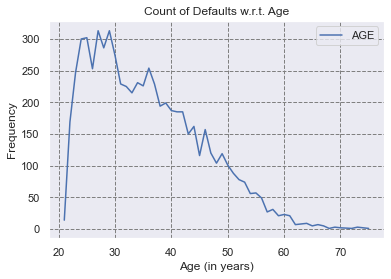

In [6]:
data[data['default.payment.next.month']==1]['AGE'].value_counts().to_frame().sort_index().plot()
plt.xlabel('Age (in years)')
plt.ylabel('Frequency')
plt.title('Count of Defaults w.r.t. Age')
plt.grid(linestyle='--', color='grey')
plt.show()

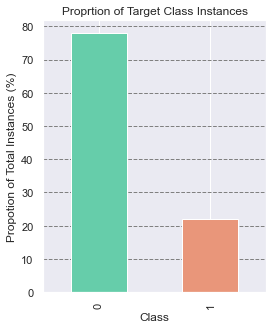

In [7]:
fig, ax = plt.subplots(figsize=(4, 5))
(data['default.payment.next.month'].value_counts() / data.shape[0] * 100).round(2).plot(kind='bar', color=['mediumaquamarine', 'darksalmon'], ax=ax)
plt.xlabel('Class')
plt.ylabel('Propotion of Total Instances (%)')
plt.title('Proprtion of Target Class Instances')
plt.grid(linestyle='--', color='grey', axis='y')
plt.show()

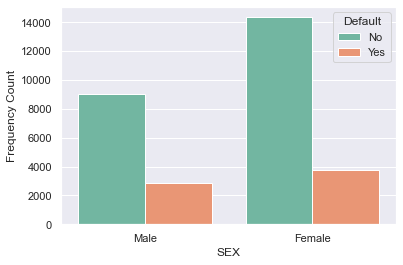

In [8]:
fig, ax = plt.subplots()
sns.countplot(data=data, x='SEX', hue='default.payment.next.month', palette='Set2', ax=ax)
plt.legend(title='Default', labels=['No', 'Yes'])
ax.set_xticklabels(['Male', 'Female'])
plt.ylabel('Frequency Count')
plt.show()

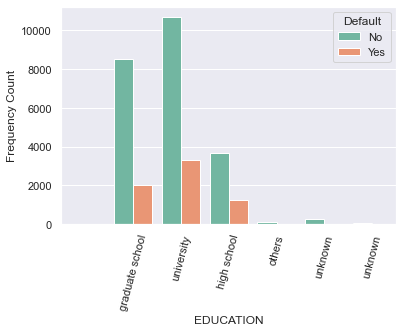

In [9]:
fig, ax = plt.subplots()
sns.countplot(data=data, x='EDUCATION', hue='default.payment.next.month', palette='Set2')
plt.legend(title='Default', labels=['No', 'Yes'])
plt.xticks([1, 2, 3, 4, 5, 6], rotation=75)
ax.set_xticklabels(['graduate school', 'university', 'high school', 'others', 'unknown', 'unknown'])
plt.ylabel('Frequency Count')
plt.show()

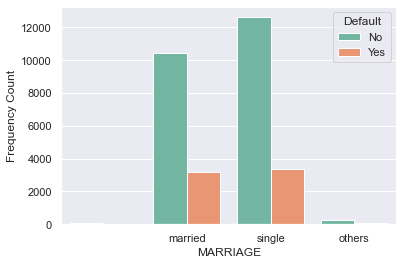

In [10]:
fig, ax = plt.subplots()
sns.countplot(data=data, x='MARRIAGE', hue='default.payment.next.month', palette='Set2', ax=ax)
plt.legend(title='Default', labels=['No', 'Yes'])
plt.xticks([1, 2, 3])
ax.set_xticklabels(['married', 'single', 'others'])
plt.ylabel('Frequency Count')
plt.show()

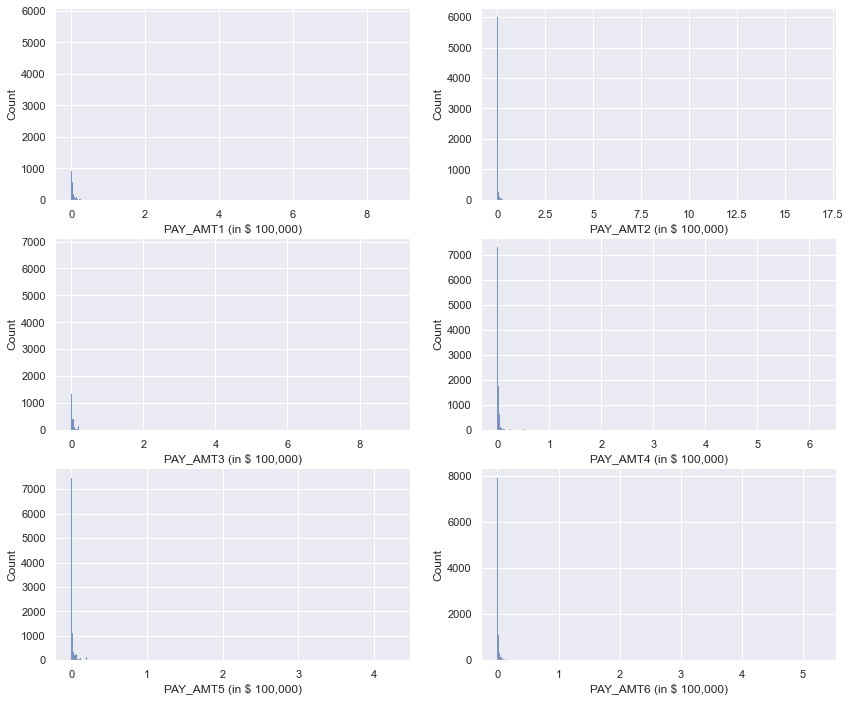

In [11]:
cols=[col for col in data.columns if 'pay_amt' in col.lower()]
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(14, 12))
ax = ax.ravel()
scale_x = 1e5
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x / scale_x))
for col, axis in zip(cols, ax):
    sns.histplot(data=data, x=col, ax=axis)
    axis.xaxis.set_major_formatter(ticks_x)
    axis.set_xlabel(f'{col} (in $ 100,000)')

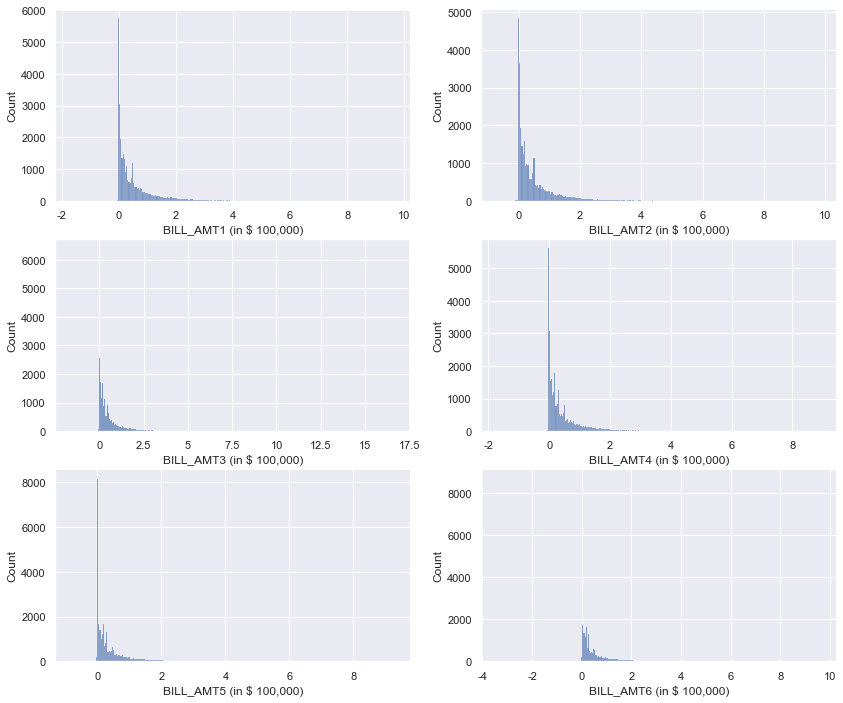

In [12]:
cols=[col for col in data.columns if 'bill_amt' in col.lower()]
fig, ax = plt.subplots(nrows=3, ncols=2, figsize=(14, 12))
ax = ax.ravel()
scale_x = 1e5
ticks_x = ticker.FuncFormatter(lambda x, pos: '{0:g}'.format(x / scale_x))
for col, axis in zip(cols, ax):
    sns.histplot(data=data, x=col, ax=axis)
    axis.xaxis.set_major_formatter(ticks_x)
    axis.set_xlabel(f'{col} (in $ 100,000)')

## Pre Processing

In [13]:
def get_dummies(data_frame, col_name):
    df = pd.DataFrame()
    
    for col in col_name:
        dummies_df = pd.get_dummies(data_frame[col], prefix=col).copy()
        
        for sub_col in dummies_df:
            df[sub_col] = pd.Categorical(dummies_df[sub_col])
    
    return df

In [14]:
def make_age_category(series):
    return pd.cut(series, bins=[0, 20, 30, 35, 40, 45, 50, 55, 60, 100])

In [15]:
def genearte_features(data_frame):
    df = data_frame.copy()
    df['avg_exp_amt_5'] = ((df['BILL_AMT5'] - (df['BILL_AMT6'] - df['PAY_AMT5']))) / df['LIMIT_BAL']
    df['avg_exp_amt_4'] = (((df['BILL_AMT5'] - (df['BILL_AMT6'] - df['PAY_AMT5'])) +
                         (df['BILL_AMT4'] - (df['BILL_AMT5'] - df['PAY_AMT4']))) / 2) / df['LIMIT_BAL']
    df['avg_exp_amt_3'] = (((df['BILL_AMT5'] - (df['BILL_AMT6'] - df['PAY_AMT5'])) +
                         (df['BILL_AMT4'] - (df['BILL_AMT5'] - df['PAY_AMT4'])) +
                         (df['BILL_AMT3'] - (df['BILL_AMT4'] - df['PAY_AMT3']))) / 3) / df['LIMIT_BAL']
    df['avg_exp_amt_2'] = (((df['BILL_AMT5'] - (df['BILL_AMT6'] - df['PAY_AMT5'])) +
                         (df['BILL_AMT4'] - (df['BILL_AMT5'] - df['PAY_AMT4'])) +
                         (df['BILL_AMT3'] - (df['BILL_AMT4'] - df['PAY_AMT3'])) +
                         (df['BILL_AMT2'] - (df['BILL_AMT3'] - df['PAY_AMT2']))) / 4) / df['LIMIT_BAL']
    df['avg_exp_amt_1'] = (((df['BILL_AMT5'] - (df['BILL_AMT6'] - df['PAY_AMT5'])) +
                         (df['BILL_AMT4'] - (df['BILL_AMT5'] - df['PAY_AMT4'])) +
                         (df['BILL_AMT3'] - (df['BILL_AMT4'] - df['PAY_AMT3'])) +
                         (df['BILL_AMT2'] - (df['BILL_AMT3'] - df['PAY_AMT2'])) +
                         (df['BILL_AMT1'] - (df['BILL_AMT2'] - df['PAY_AMT1']))) / 5) / df['LIMIT_BAL']
    
    df['closeness_6'] = 1 - df['BILL_AMT6'] / df['LIMIT_BAL']
    df['closeness_5'] = 1 - df['BILL_AMT5'] / df['LIMIT_BAL']
    df['closeness_4'] = 1 - df['BILL_AMT4'] / df['LIMIT_BAL']
    df['closeness_3'] = 1 - df['BILL_AMT3'] / df['LIMIT_BAL']
    df['closeness_2'] = 1 - df['BILL_AMT2'] / df['LIMIT_BAL']
    df['closeness_1'] = 1 - df['BILL_AMT1'] / df['LIMIT_BAL']
    return df

In [16]:
def pre_process(data_frame):
    df = data_frame.copy()
    df.reset_index(drop=True, inplace=True)
    df.drop('ID', axis=1, inplace=True)
    #rename columns
    df.rename(columns={'default.payment.next.month': 'default'}, inplace=True)
    #generate features
    df = genearte_features(data_frame=df)
    #Making categorical age variable
    df['AGE_grouped'] = make_age_category(series=df['AGE'])
    #creating dummies for categorical variable
    dummies = get_dummies(data_frame=df, 
                          col_name=['AGE_grouped', 'SEX', 'EDUCATION', 'MARRIAGE', 
                                    'PAY_0', 'PAY_2', 'PAY_3', 'PAY_4', 'PAY_5', 'PAY_6'])
    amount_df = df[[col for col in df if ('amt' in col.lower()) | ('bal' in col.lower())]]
    target = df['default']
    df = pd.concat([amount_df, dummies, target], axis=1).copy()
    return df

## Modelling

In [17]:
def min_max_normalize(train_df, test_df):
    #Normalizing skewed variables
    scaler = MinMaxScaler()
    scaled = scaler.fit_transform(train_df)
    train_scaled = pd.DataFrame(scaled, columns=train_df.columns)
    test_scaled = pd.DataFrame(scaler.transform(test_df), columns=test_df.columns)
    return train_scaled, test_scaled

def reduce_dimention(train_df, test_df):
    pca = PCA(n_components=20)
    train_reduced = pca.fit_transform(train_df)
    test_reduced = pca.transform(test_df)
    return train_reduced, test_reduced

In [18]:
def select_model(model_name, bbc):
    if model_name.lower() == 'naive_bayes':
        model = GaussianNB()
    elif model_name.lower() == 'log_reg':
        model = LogisticRegression(solver='saga')
    elif model_name.lower() == 'dtrees':
        model = DecisionTreeClassifier()
    elif model_name.lower() == 'extrees':
        model = ExtraTreesClassifier()
    elif model_name.lower() == 'rforest':
        model=RandomForestClassifier()
    elif model_name.lower() == 'svc':
        model = SVC(gamma='auto', probability=True)
    else:
        raise ValueError(f'Model {model_name} is not supported.')
    
    if bbc:
        model = BalancedBaggingClassifier(base_estimator=model,
                                            sampling_strategy='not majority',
                                            replacement=False)
    
    return model

In [19]:
def to_labels(positive_probs, threshold):
    "If labels are {0, 1}"
    return (positive_probs >= threshold).astype('int')

def cal_optimal_threshold(y_test, positive_probs, method):
    """
    Methods supported are f1score, roc
    f1score - mximising f1score for various thresholds
    roc - Maximising True Positive Rate minus False Positive Rate (TPR - FPR) for various threshold
    """
    if method == 'f1score':
        thresholds = np.arange(0, 1.001, 0.001)
        scores = [f1_score(y_test, to_labels(positive_probs, t)) for t in thresholds]
        optimal_idx = np.argmax(scores)
        opt_threshold = thresholds[optimal_idx]
        opt_val = scores[optimal_idx]
    elif method == 'roc':
        fpr, tpr, thresholds = roc_curve(y_test, positive_probs)
        optimal_idx = np.argmax(tpr - fpr)
        opt_threshold = thresholds[optimal_idx]
        opt_val = tpr[optimal_idx] - fpr[optimal_idx]
    else:
        raise ValueError('Method supported are f1score, roc')
    
    return opt_threshold, opt_val

In [20]:
def print_confusion_matrix(y_test, predictions, labels):
    #accuracy measure
    cm = confusion_matrix(y_test, predictions, labels=labels)
    print('******************************')
    print('Confusion Matrix')
    disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                                  display_labels=labels)
    disp.plot()
    plt.show()

In [21]:
def compute_metrics(y_test, predictions):
    metric = precision_recall_fscore_support(y_true = y_test, y_pred = predictions)
    metric = np.around(metric, 2)
    recall0 = round(recall_score(y_true = y_test, y_pred = predictions, pos_label=0), 2)
    recall1 = round(recall_score(y_true = y_test, y_pred = predictions, pos_label=1), 2)
    accuracy = round(accuracy_score(y_true = y_test, y_pred = predictions), 2)
    return {'precision0': metric[0][0], 'precision1': metric[0][1],
            'recall0': recall0, 'recall1': recall1, 
            'f1score0': metric[2][0], 'f1score1': metric[2][1],
            'support0': int(metric[3][0]), 'support1': int(metric[3][1]),
            'accuracy': accuracy}

def print_classification_report(y_test, predictions):
    print('******************************')
    print('Classification Report')
    metric = precision_recall_fscore_support(y_true = y_test, y_pred = predictions)
    metric = np.around(metric, 2)
    recall0 = round(recall_score(y_true = y_test, y_pred = predictions, pos_label=0), 2)
    recall1 = round(recall_score(y_true = y_test, y_pred = predictions, pos_label=1), 2)
    accuracy = round(accuracy_score(y_true = y_test, y_pred = predictions), 2)
    output = f'       precision     recall    f1-score    support\n\n\
    0      {metric[0][0]:.2f}       {recall0:.2f}        {metric[2][0]:.2f}       {int(metric[3][0])}\n\
    1      {metric[0][1]:.2f}       {recall1:.2f}        {metric[2][1]:.2f}       {int(metric[3][1])}\n\
    accuracy = {accuracy:.2f}'
    print(output)

In [22]:
def print_tpr_fpr(y_test, predictions, labels):
    cm = confusion_matrix(y_test, predictions, labels=labels)
    tpr_score = cm[1][1] / (cm[1][1] + cm[1][0]) #sensitivity, Recall
    fpr_score = cm[0][1] / (cm[0][1] + cm[0][0]) #specificity
    print('******************************')
    print('True Positive Rate / Sensitivity / Recall =', round(tpr_score, 2))
    print('False Positive Rate =', round(fpr_score, 2))
    print('Specificity =', round(1-fpr_score, 2))

In [23]:
def print_roc_curve(y_test, probs, optimal_threshold):
    print('******************************')
    fpr, tpr, thresholds = roc_curve(y_test, probs)
    plt.plot(fpr, tpr, label='ROC Curve')
    val = np.arange(0, 1.1, 0.1)
    plt.plot(val, val, linestyle='--', color='red', label='No Skill')
    idx = np.argmin(abs(thresholds - optimal_threshold))
    best_fpr = fpr[idx]
    best_tpr = tpr[idx]
    plt.plot(best_fpr, best_tpr, marker='o', color='black', label='best')
    plt.title('Receiver Operating Characteristic Curve | Test Data | Positive Class')
    plt.xlabel('False Positive Rate (Fall Out)')
    plt.ylabel('True Positive Rate (Recall)')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.grid(linestyle='--', color='grey')
    plt.legend()
    plt.show()
    print('The dot represents True Positive Rate and False Positive Rate\
    \nof the predictions for optimal threshold.')
    auc = roc_auc_score(y_test, probs)
    auc = round(auc, 2)
    print('******************************')
    print(f'Area Under ROC Curve is {auc}')

In [24]:
def print_precision_recall_cuve(y_test, probs, optimal_threshold):
    print('******************************')
    precision, recall, thresholds = precision_recall_curve(y_true = y_test, probas_pred = probs)
    # plot the precision-recall curves
    no_skill = len(y_test[y_test==1]) / len(y_test)
    plt.plot(recall, precision, label=f'PR Curve')
    plt.plot([0, 1], [no_skill, no_skill], linestyle='--', color='red', label='No Skill')
    idx = np.argmin(abs(thresholds - optimal_threshold))
    best_precision = precision[idx]
    best_recall = recall[idx]
    plt.plot(best_recall, best_precision, marker='o', color='black', label='best')
    plt.title('Precision Recall Curve | Test Data | Positive Class')
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.xlim([0, 1])
    plt.ylim([0, 1])
    plt.grid(linestyle='--', color='grey')
    plt.legend()
    plt.show()
    print('The dot represents Precision and Recall of the predictions\
    \nfor optimal threshold.')

In [25]:
def model_training(data_frame, model_name, bbc=False):
    t1_start = perf_counter()
    #Preprocess data
    df = pre_process(data_frame=data_frame)
    
    #train test split
    x = df.drop('default', axis=1)
    y = df['default']
    x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)
    
    if model_name not in ['dtrees', 'extrees', 'rforest']:
        x_train, x_test = min_max_normalize(train_df=x_train, test_df=x_test)
        x_train, x_test = reduce_dimention(train_df=x_train, test_df=x_test)
    
    #model fitting
    model = select_model(model_name=model_name, bbc=bbc)
    model.fit(x_train, y_train)
    print(f'Fitted Model to Train Data: {model_name}')
    
    #making predictions
    probs = model.predict_proba(x_test)[:, 1] #probability of 1 for all the test instances 
    optimal_threshold, _ = cal_optimal_threshold(y_test=y_test, positive_probs=probs, method='roc')
    print('******************************')
    print(f'Optimal Threshold is {round(optimal_threshold, 2)} (method: roc)')
    predictions = to_labels(positive_probs=probs, threshold=optimal_threshold)
    
    score = model.score(x_train, y_train)
    score1 = model.score(x_test, y_test)
    print('******************************')
    print('Train Score =', round(score, 2))
    print('Test Score =', round(score1, 2))
    
    print_confusion_matrix(y_test=y_test, predictions=predictions, labels=model.classes_)
    print_classification_report(y_test=y_test, predictions=predictions)
    print_tpr_fpr(y_test=y_test, predictions=predictions, labels=model.classes_)
    print_roc_curve(y_test=y_test, probs=probs, optimal_threshold=optimal_threshold)
    print_precision_recall_cuve(y_test=y_test, probs=probs, optimal_threshold=optimal_threshold)
    
    t1_stop = perf_counter()
    print('******************************')
    print("Elapsed time during the whole program:", round(t1_stop-t1_start, 2), 'Seconds' )
    print('******************************')
    return compute_metrics(y_test=y_test, predictions=predictions)

Fitted Model to Train Data: log_reg
******************************
Optimal Threshold is 0.2 (method: roc)
******************************
Train Score = 0.81
Test Score = 0.81
******************************
Confusion Matrix


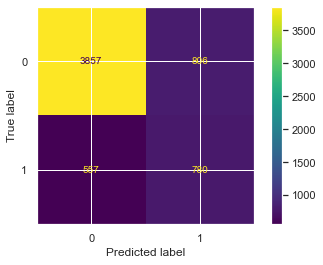

******************************
Classification Report
       precision     recall    f1-score    support

    0      0.87       0.83        0.85       4663
    1      0.49       0.58        0.53       1337
    accuracy = 0.77
******************************
True Positive Rate / Sensitivity / Recall = 0.58
False Positive Rate = 0.17
Specificity = 0.83
******************************


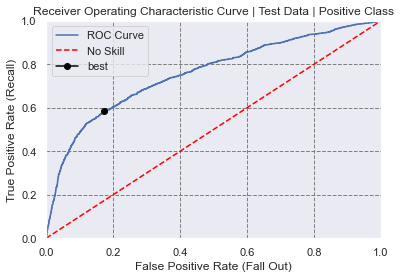

The dot represents True Positive Rate and False Positive Rate    
of the predictions for optimal threshold.
******************************
Area Under ROC Curve is 0.76
******************************


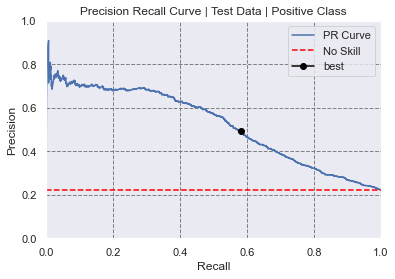

The dot represents Precision and Recall of the predictions    
for optimal threshold.
******************************
Elapsed time during the whole program: 1.04 Seconds
******************************


In [26]:
a=model_training(data_frame=data, model_name='log_reg')

### Resampling

In [27]:
def upsample_data_resample(data_frame):
    #create two different dataframe of majority and minority class 
    df_majority = data_frame[data_frame['default.payment.next.month'] == 0]
    df_minority = data_frame[data_frame['default.payment.next.month'] == 1].copy()
    # upsample minority class
    df_minority_upsampled = resample(df_minority, 
                                     replace=True,    # sample with replacement
                                     n_samples= df_majority.shape[0]) # to match majority class
    # Combine majority class with upsampled minority class
    return pd.concat([df_minority_upsampled, df_majority]).copy()

In [28]:
resample_data = upsample_data_resample(data_frame=data)

In [29]:
(resample_data['default.payment.next.month'].value_counts() / resample_data.shape[0] * 100).to_dict()

{1: 50.0, 0: 50.0}

Fitted Model to Train Data: log_reg
******************************
Optimal Threshold is 0.48 (method: roc)
******************************
Train Score = 0.7
Test Score = 0.71
******************************
Confusion Matrix


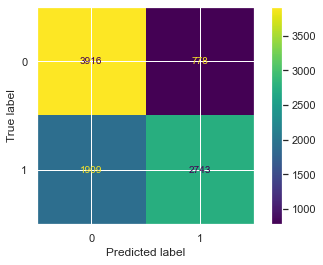

******************************
Classification Report
       precision     recall    f1-score    support

    0      0.67       0.83        0.74       4694
    1      0.78       0.59        0.67       4652
    accuracy = 0.71
******************************
True Positive Rate / Sensitivity / Recall = 0.59
False Positive Rate = 0.17
Specificity = 0.83
******************************


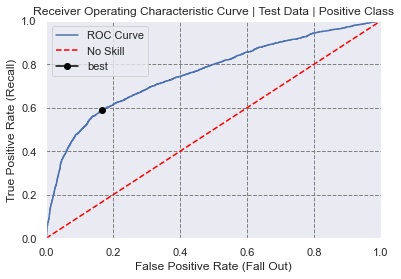

The dot represents True Positive Rate and False Positive Rate    
of the predictions for optimal threshold.
******************************
Area Under ROC Curve is 0.76
******************************


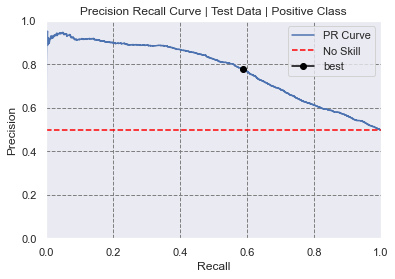

The dot represents Precision and Recall of the predictions    
for optimal threshold.
******************************
Elapsed time during the whole program: 1.34 Seconds
******************************


In [30]:
b=model_training(data_frame=resample_data, model_name='log_reg')

Fitted Model to Train Data: extrees
******************************
Optimal Threshold is 0.99 (method: roc)
******************************
Train Score = 1.0
Test Score = 0.94
******************************
Confusion Matrix


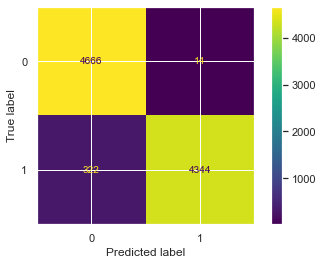

******************************
Classification Report
       precision     recall    f1-score    support

    0      0.94       1.00        0.97       4680
    1      1.00       0.93        0.96       4666
    accuracy = 0.96
******************************
True Positive Rate / Sensitivity / Recall = 0.93
False Positive Rate = 0.0
Specificity = 1.0
******************************


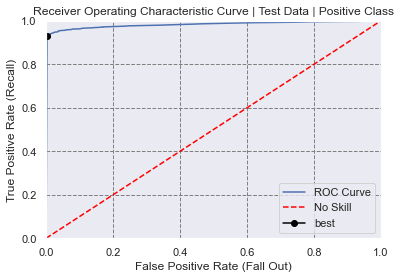

The dot represents True Positive Rate and False Positive Rate    
of the predictions for optimal threshold.
******************************
Area Under ROC Curve is 0.98
******************************


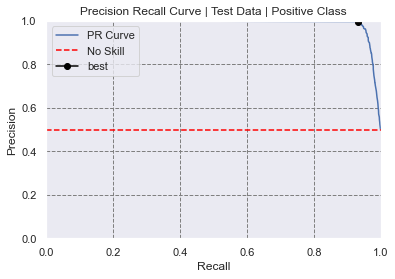

The dot represents Precision and Recall of the predictions    
for optimal threshold.
******************************
Elapsed time during the whole program: 8.81 Seconds
******************************


In [31]:
c=model_training(data_frame=resample_data, model_name='extrees')

Fitted Model to Train Data: rforest
******************************
Optimal Threshold is 0.66 (method: roc)
******************************
Train Score = 1.0
Test Score = 0.94
******************************
Confusion Matrix


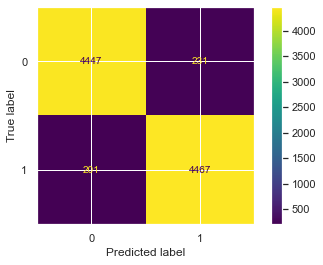

******************************
Classification Report
       precision     recall    f1-score    support

    0      0.96       0.95        0.95       4678
    1      0.95       0.96        0.95       4668
    accuracy = 0.95
******************************
True Positive Rate / Sensitivity / Recall = 0.96
False Positive Rate = 0.05
Specificity = 0.95
******************************


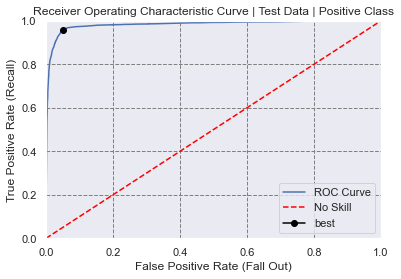

The dot represents True Positive Rate and False Positive Rate    
of the predictions for optimal threshold.
******************************
Area Under ROC Curve is 0.98
******************************


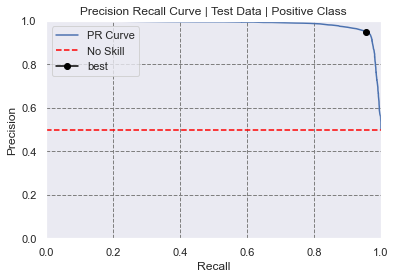

The dot represents Precision and Recall of the predictions    
for optimal threshold.
******************************
Elapsed time during the whole program: 9.08 Seconds
******************************


In [32]:
d=model_training(data_frame=resample_data, model_name='rforest')

### SMOTE

In [33]:
#Synthetic Minority Oversampling Technique

In [34]:
def upsample_data_smote(data_frame):
    df = data_frame.copy()
    sm = SMOTE(sampling_strategy='minority')
    oversampled_X, oversampled_Y = sm.fit_resample(df.drop('default.payment.next.month', axis=1), 
                                                   df[['default.payment.next.month']])
    return pd.concat([oversampled_X, oversampled_Y], axis=1).copy()

In [35]:
oversampled_data = upsample_data_smote(data_frame=data)
(oversampled_data['default.payment.next.month'].value_counts() / oversampled_data.shape[0] * 100).to_dict()

{1: 50.0, 0: 50.0}

Fitted Model to Train Data: naive_bayes
******************************
Optimal Threshold is 0.4 (method: roc)
******************************
Train Score = 0.68
Test Score = 0.68
******************************
Confusion Matrix


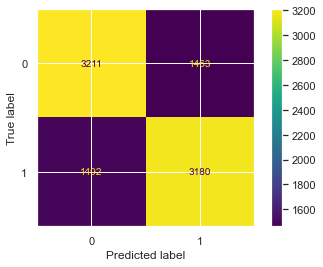

******************************
Classification Report
       precision     recall    f1-score    support

    0      0.68       0.69        0.68       4674
    1      0.68       0.68        0.68       4672
    accuracy = 0.68
******************************
True Positive Rate / Sensitivity / Recall = 0.68
False Positive Rate = 0.31
Specificity = 0.69
******************************


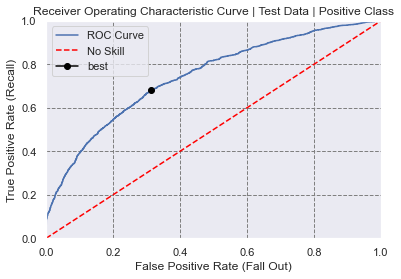

The dot represents True Positive Rate and False Positive Rate    
of the predictions for optimal threshold.
******************************
Area Under ROC Curve is 0.74
******************************


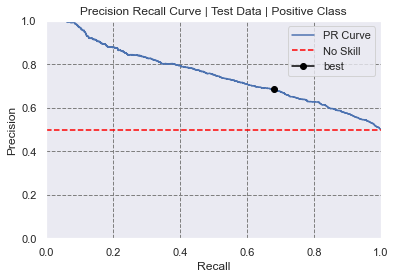

The dot represents Precision and Recall of the predictions    
for optimal threshold.
******************************
Elapsed time during the whole program: 1.1 Seconds
******************************


In [36]:
e=model_training(data_frame=oversampled_data, model_name='naive_bayes')

Fitted Model to Train Data: log_reg
******************************
Optimal Threshold is 0.49 (method: roc)
******************************
Train Score = 0.74
Test Score = 0.73
******************************
Confusion Matrix


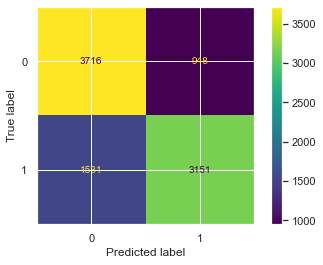

******************************
Classification Report
       precision     recall    f1-score    support

    0      0.71       0.80        0.75       4664
    1      0.77       0.67        0.72       4682
    accuracy = 0.73
******************************
True Positive Rate / Sensitivity / Recall = 0.67
False Positive Rate = 0.2
Specificity = 0.8
******************************


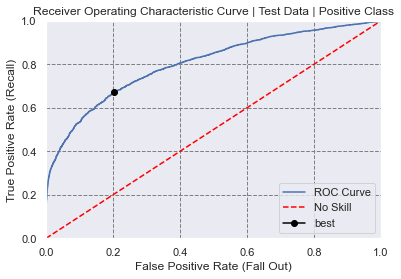

The dot represents True Positive Rate and False Positive Rate    
of the predictions for optimal threshold.
******************************
Area Under ROC Curve is 0.8
******************************


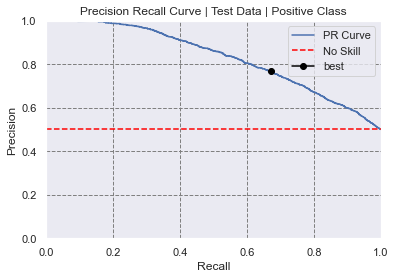

The dot represents Precision and Recall of the predictions    
for optimal threshold.
******************************
Elapsed time during the whole program: 1.17 Seconds
******************************


In [37]:
f=model_training(data_frame=oversampled_data, model_name='log_reg')

Fitted Model to Train Data: dtrees
******************************
Optimal Threshold is 0.67 (method: roc)
******************************
Train Score = 1.0
Test Score = 0.76
******************************
Confusion Matrix


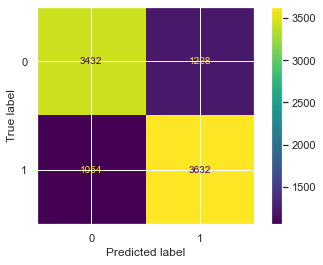

******************************
Classification Report
       precision     recall    f1-score    support

    0      0.77       0.74        0.75       4660
    1      0.75       0.78        0.76       4686
    accuracy = 0.76
******************************
True Positive Rate / Sensitivity / Recall = 0.78
False Positive Rate = 0.26
Specificity = 0.74
******************************


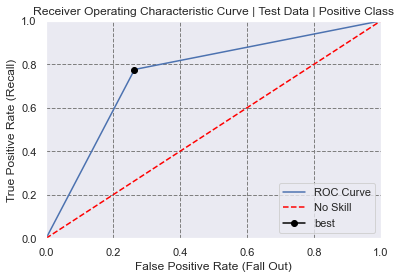

The dot represents True Positive Rate and False Positive Rate    
of the predictions for optimal threshold.
******************************
Area Under ROC Curve is 0.76
******************************


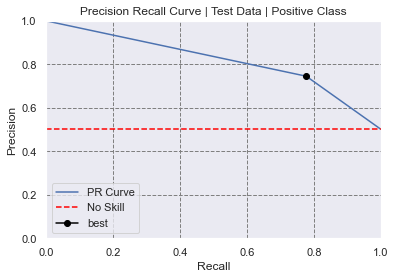

The dot represents Precision and Recall of the predictions    
for optimal threshold.
******************************
Elapsed time during the whole program: 1.71 Seconds
******************************


In [38]:
g=model_training(data_frame=oversampled_data, model_name='dtrees')

Fitted Model to Train Data: extrees
******************************
Optimal Threshold is 0.56 (method: roc)
******************************
Train Score = 1.0
Test Score = 0.82
******************************
Confusion Matrix


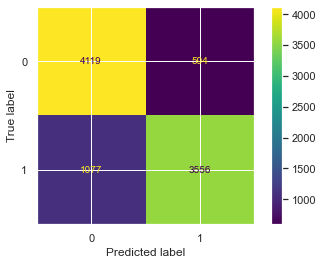

******************************
Classification Report
       precision     recall    f1-score    support

    0      0.79       0.87        0.83       4713
    1      0.86       0.77        0.81       4633
    accuracy = 0.82
******************************
True Positive Rate / Sensitivity / Recall = 0.77
False Positive Rate = 0.13
Specificity = 0.87
******************************


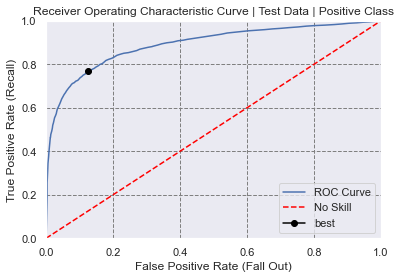

The dot represents True Positive Rate and False Positive Rate    
of the predictions for optimal threshold.
******************************
Area Under ROC Curve is 0.89
******************************


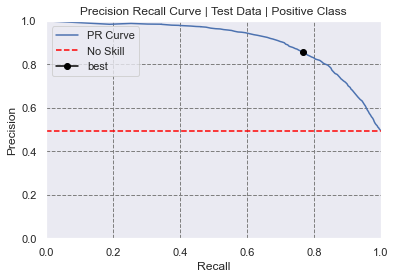

The dot represents Precision and Recall of the predictions    
for optimal threshold.
******************************
Elapsed time during the whole program: 8.01 Seconds
******************************


In [39]:
h=model_training(data_frame=oversampled_data, model_name='extrees')

Fitted Model to Train Data: rforest
******************************
Optimal Threshold is 0.52 (method: roc)
******************************
Train Score = 1.0
Test Score = 0.83
******************************
Confusion Matrix


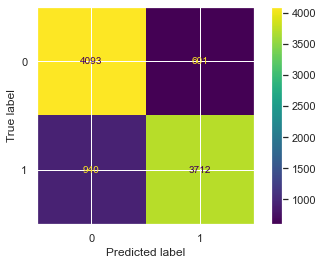

******************************
Classification Report
       precision     recall    f1-score    support

    0      0.81       0.87        0.84       4694
    1      0.86       0.80        0.83       4652
    accuracy = 0.84
******************************
True Positive Rate / Sensitivity / Recall = 0.8
False Positive Rate = 0.13
Specificity = 0.87
******************************


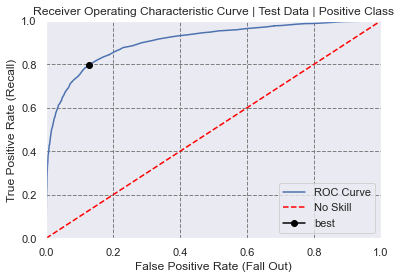

The dot represents True Positive Rate and False Positive Rate    
of the predictions for optimal threshold.
******************************
Area Under ROC Curve is 0.91
******************************


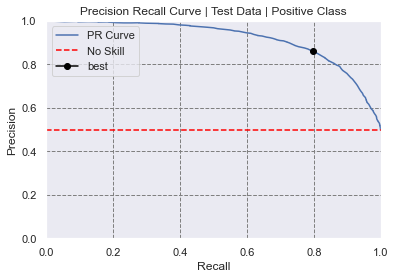

The dot represents Precision and Recall of the predictions    
for optimal threshold.
******************************
Elapsed time during the whole program: 9.02 Seconds
******************************


In [40]:
i=model_training(data_frame=oversampled_data, model_name='rforest')

Fitted Model to Train Data: svc
******************************
Optimal Threshold is 0.42 (method: roc)
******************************
Train Score = 0.75
Test Score = 0.75
******************************
Confusion Matrix


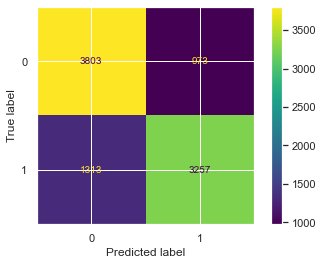

******************************
Classification Report
       precision     recall    f1-score    support

    0      0.74       0.80        0.77       4776
    1      0.77       0.71        0.74       4570
    accuracy = 0.76
******************************
True Positive Rate / Sensitivity / Recall = 0.71
False Positive Rate = 0.2
Specificity = 0.8
******************************


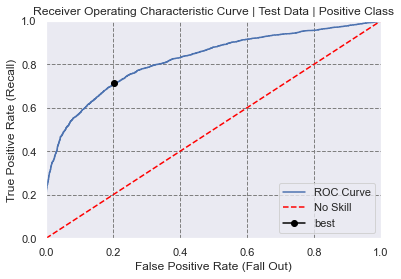

The dot represents True Positive Rate and False Positive Rate    
of the predictions for optimal threshold.
******************************
Area Under ROC Curve is 0.82
******************************


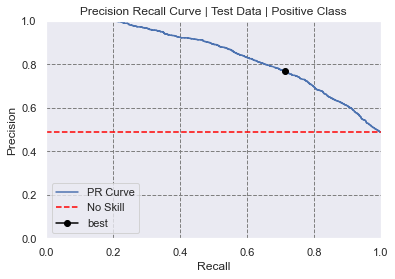

The dot represents Precision and Recall of the predictions    
for optimal threshold.
******************************
Elapsed time during the whole program: 393.67 Seconds
******************************


In [41]:
j=model_training(data_frame=oversampled_data, model_name='svc')

### Balanced Bagging Classifier

Fitted Model to Train Data: extrees
******************************
Optimal Threshold is 0.22 (method: roc)
******************************
Train Score = 0.99
Test Score = 0.81
******************************
Confusion Matrix


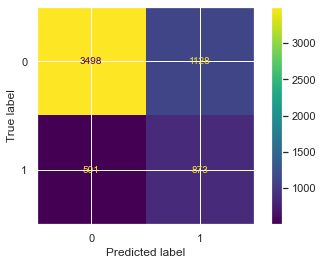

******************************
Classification Report
       precision     recall    f1-score    support

    0      0.87       0.76        0.81       4626
    1      0.44       0.64        0.52       1374
    accuracy = 0.73
******************************
True Positive Rate / Sensitivity / Recall = 0.64
False Positive Rate = 0.24
Specificity = 0.76
******************************


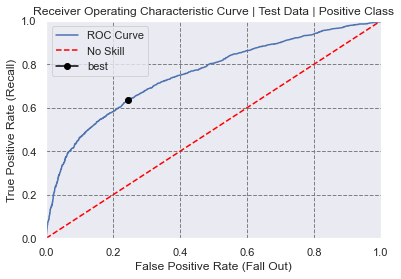

The dot represents True Positive Rate and False Positive Rate    
of the predictions for optimal threshold.
******************************
Area Under ROC Curve is 0.76
******************************


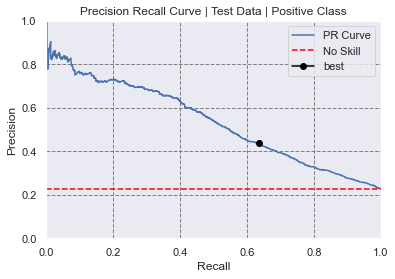

The dot represents Precision and Recall of the predictions    
for optimal threshold.
******************************
Elapsed time during the whole program: 35.81 Seconds
******************************


In [42]:
k=model_training(data_frame=data, model_name='extrees', bbc=True)

Fitted Model to Train Data: rforest
******************************
Optimal Threshold is 0.3 (method: roc)
******************************
Train Score = 0.97
Test Score = 0.82
******************************
Confusion Matrix


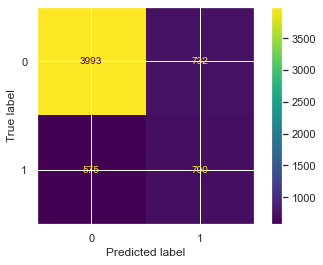

******************************
Classification Report
       precision     recall    f1-score    support

    0      0.87       0.85        0.86       4725
    1      0.49       0.55        0.52       1275
    accuracy = 0.78
******************************
True Positive Rate / Sensitivity / Recall = 0.55
False Positive Rate = 0.15
Specificity = 0.85
******************************


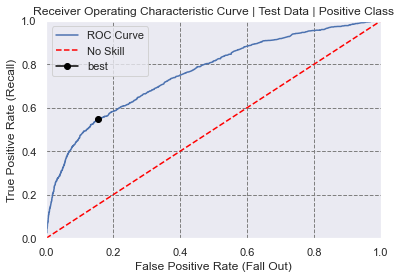

The dot represents True Positive Rate and False Positive Rate    
of the predictions for optimal threshold.
******************************
Area Under ROC Curve is 0.76
******************************


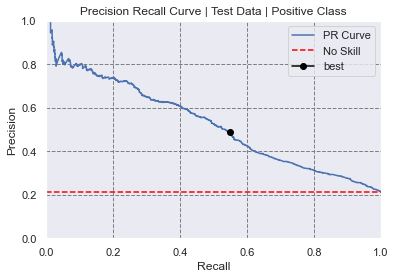

The dot represents Precision and Recall of the predictions    
for optimal threshold.
******************************
Elapsed time during the whole program: 45.76 Seconds
******************************


In [43]:
l=model_training(data_frame=data, model_name='rforest', bbc=True)

### Comparison

In [44]:
data_rows = [('original', 'Logistic Regression', a['f1score1'], a['precision1'], a['recall1'], a['accuracy']),
             ('Resampled', 'Logistic Regression', b['f1score1'], b['precision1'], b['recall1'], b['accuracy']),
             ('Resampled', 'Extra Trees', c['f1score1'], c['precision1'], c['recall1'], c['accuracy']),
             ('Resampled', 'Random Forest', d['f1score1'], d['precision1'], d['recall1'], d['accuracy']),
             ('SMOTE', 'Naive Bayes', e['f1score1'], e['precision1'], e['recall1'], e['accuracy']),
             ('SMOTE', 'Logistic Regression', f['f1score1'], f['precision1'], f['recall1'], f['accuracy']),
             ('SMOTE', 'Decision Tree', g['f1score1'], g['precision1'], g['recall1'], g['accuracy']),
             ('SMOTE', 'Extra Trees', h['f1score1'], h['precision1'], h['recall1'], h['accuracy']),
             ('SMOTE', 'Random Forest', i['f1score1'], i['precision1'], i['recall1'], i['accuracy']),
             ('SMOTE', 'Support Vector Machine', j['f1score1'], j['precision1'], j['recall1'], j['accuracy']),
             ('Balanced Bagging', 'Extra Trees', k['f1score1'], k['precision1'], k['recall1'], k['accuracy']),
             ('Balanced Bagging', 'Random Forest', l['f1score1'], l['precision1'], l['recall1'], l['accuracy']),
            ]
t = Table(rows=data_rows, names=('Data', 'Model', 'F1-score', 'Precision', 'Recall', 'Accuracy'))
print(t)

      Data               Model          F1-score Precision Recall Accuracy
---------------- ---------------------- -------- --------- ------ --------
        original    Logistic Regression     0.53      0.49   0.58     0.77
       Resampled    Logistic Regression     0.67      0.78   0.59     0.71
       Resampled            Extra Trees     0.96       1.0   0.93     0.96
       Resampled          Random Forest     0.95      0.95   0.96     0.95
           SMOTE            Naive Bayes     0.68      0.68   0.68     0.68
           SMOTE    Logistic Regression     0.72      0.77   0.67     0.73
           SMOTE          Decision Tree     0.76      0.75   0.78     0.76
           SMOTE            Extra Trees     0.81      0.86   0.77     0.82
           SMOTE          Random Forest     0.83      0.86    0.8     0.84
           SMOTE Support Vector Machine     0.74      0.77   0.71     0.76
Balanced Bagging            Extra Trees     0.52      0.44   0.64     0.73
Balanced Bagging         

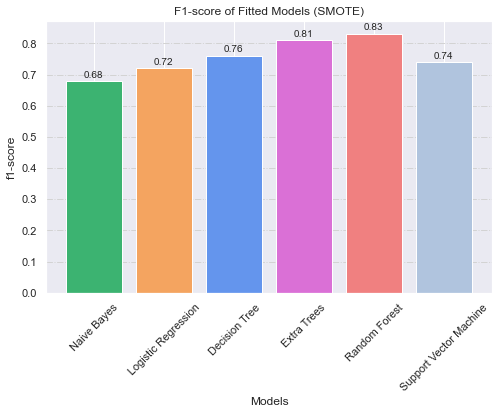

In [45]:
x=['Naive Bayes', 'Logistic Regression', 'Decision Tree', 'Extra Trees', 'Random Forest', 'Support Vector Machine']
y=[e['f1score1'], f['f1score1'], g['f1score1'], h['f1score1'], i['f1score1'], j['f1score1']]
fig, ax = plt.subplots(figsize=(8,5))
bar_plot = ax.bar(x, y, color=['mediumseagreen', 'sandybrown', 'cornflowerblue', 'orchid', 'lightcoral', 'lightsteelblue'])

for iterator, bar in enumerate(bar_plot):
    ax.text(bar.get_x() + 0.25, 
            1.015*bar.get_height(),
            str(bar.get_height()))

plt.xticks(rotation = 45)
plt.title('F1-score of Fitted Models (SMOTE)')
plt.xlabel('Models')
plt.ylabel('f1-score')
plt.grid(linestyle='-.', color='lightgrey', axis='y')
plt.show()

'best model is SMOTE - Random Forest because good fit, nice roc and pr curve, acceptable optimal threshold, robust, logically correct to do smote as resampling causes overfitiing to same data'